In [ ]:
# !pip install --upgrade torch torchvision torchaudio
# !pip install torch-xla --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
import pandas as pd
from google.colab import drive
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer
import torch
import torch.nn as nn
from transformers import AutoModel, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
political_bias_fake_df = pd.read_excel('/content/drive/MyDrive/Political Bais/Political Fake.xlsx')  # Ensure columns: 'text', 'label_fake', 'label_bias'
political_bias_real_df = pd.read_excel('/content/drive/MyDrive/Political Bais/Political Real.xlsx')  # Ensure columns: 'text', 'label_fake', 'label_bias'

political_bias_df = pd.concat([political_bias_fake_df, political_bias_real_df], axis=0).reset_index(drop=True)

political_bias_df.head(5)

,text,label_fake,label_bias
0,ශ්‍රී ලංකාවේ ඉන්දීය මහ කොමසාරිස් කාර්යාලය රාජප...,1,1
1,ශ්‍රී ලාංකිකයන්ට වීසා බලපත්‍ර නොමැතිව ඇමරිකාවට...,1,1
2,2016 වසරේ ඇමරිකානු ජනාධිපතිවරණයට ශ්‍රී ලාංකික ...,1,1
3,"මට සංවිධානාත්මකව මඩ ගහනවා. මාව කොටියෙක් කරලා, ...",1,1
4,මුදල් අච්චු ගැසීම සැබවින්ම මෙරට දේශපාලනයේ ආන්ද...,1,1


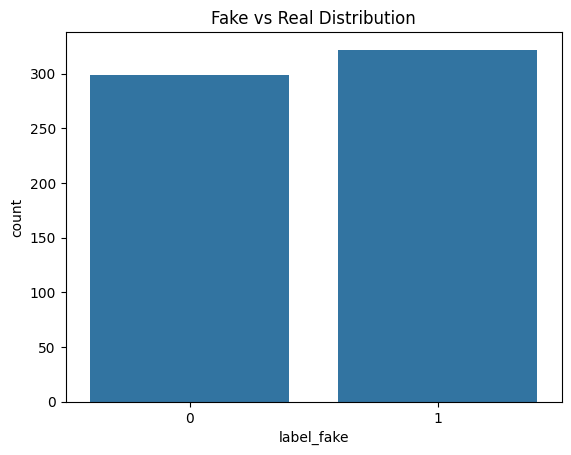

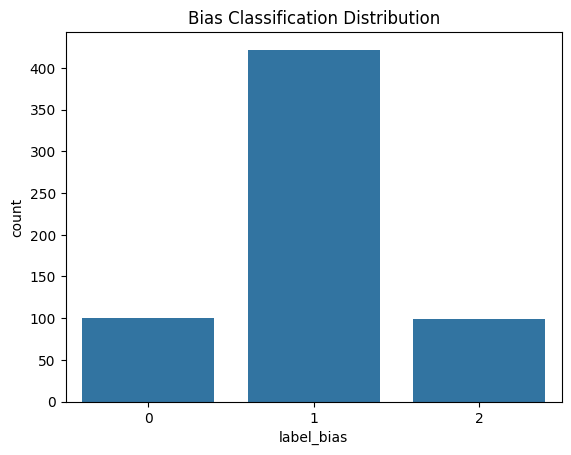

In [ ]:
sns.countplot(x=political_bias_df["label_fake"])
plt.title("Fake vs Real Distribution")
plt.show()

sns.countplot(x=political_bias_df["label_bias"])
plt.title("Bias Classification Distribution")
plt.show()

In [ ]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained("NLPC-UOM/SinBERT-large")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Splitting dataset
train_texts, val_texts, train_labels_fake, val_labels_fake, train_labels_bias, val_labels_bias = train_test_split(
    political_bias_df["text"], political_bias_df["label_fake"], political_bias_df["label_bias"], test_size=0.2, random_state=42
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self, model_name, num_labels_fake, num_labels_bias):
        super(MultiTaskModel, self).__init__()
        self.base_model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)

        # Two classifiers: one for fake/real, one for bias classification
        self.classifier_fake = nn.Linear(self.base_model.config.hidden_size, num_labels_fake)
        self.classifier_bias = nn.Linear(self.base_model.config.hidden_size, num_labels_bias)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        pooled_output = self.dropout(pooled_output)
        logits_fake = self.classifier_fake(pooled_output)
        logits_bias = self.classifier_bias(pooled_output)

        return logits_fake, logits_bias

# Instantiate Model
model = MultiTaskModel("NLPC-UOM/SinBERT-large", num_labels_fake=2, num_labels_bias=3)

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at NLPC-UOM/SinBERT-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels_fake, labels_bias, tokenizer, max_length=256):
        self.texts = texts
        self.labels_fake = labels_fake
        self.labels_bias = labels_bias
        self.tokenizer = tokenizer
        self.max_length = max_length  # Set a fixed max length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        inputs = self.tokenizer(
            text,
            padding="max_length",  # Ensures all sequences have the same length
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        label_fake = torch.tensor(self.labels_fake.iloc[idx], dtype=torch.long)
        label_bias = torch.tensor(self.labels_bias.iloc[idx], dtype=torch.long)

        return {
            "input_ids": inputs["input_ids"].squeeze(0),  # Ensure correct tensor shape
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "label_fake": label_fake,
            "label_bias": label_bias
        }

# Create datasets and dataloaders
train_dataset = CustomDataset(train_texts, train_labels_fake, train_labels_bias, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels_fake, val_labels_bias, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(15):  # You can increase epochs
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels_fake = batch["label_fake"].to(device)
        labels_bias = batch["label_bias"].to(device)

        logits_fake, logits_bias = model(input_ids, attention_mask)

        loss_fake = F.cross_entropy(logits_fake, labels_fake)
        loss_bias = F.cross_entropy(logits_bias, labels_bias)

        loss = loss_fake + loss_bias
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 74.1390
Epoch 2, Loss: 40.6840
Epoch 3, Loss: 23.9580
Epoch 4, Loss: 17.4913
Epoch 5, Loss: 10.1054
Epoch 6, Loss: 4.7567
Epoch 7, Loss: 2.3501
Epoch 8, Loss: 1.4511
Epoch 9, Loss: 0.8292
Epoch 10, Loss: 0.7618
Epoch 11, Loss: 0.4746
Epoch 12, Loss: 0.4046
Epoch 13, Loss: 0.3341
Epoch 14, Loss: 0.3236
Epoch 15, Loss: 0.3170


In [ ]:
#torch.save(model.state_dict(), "/content/drive/MyDrive/sinhala/political biased/multi_task_model.pth")
#model.load_state_dict(torch.load("/content/drive/MyDrive/sinhala/political biased/multi_task_model.pth", map_location=device))



IndentationError: unexpected indent (<ipython-input-15-0289d853ff05>, line 2)

In [ ]:
label_fake_map = {0: "real", 1: "fake"}
label_bias_map = {0: "unbiased", 1: "biased", 2: "neutral"}

In [ ]:
import torch.nn.functional as F

def predict_with_probs(text, model, tokenizer):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True).to(device)

    with torch.no_grad():
        logits_fake, logits_bias = model(inputs["input_ids"], inputs["attention_mask"])

    # Convert logits to probabilities using softmax
    probs_fake = F.softmax(logits_fake, dim=1).squeeze().cpu().tolist()
    probs_bias = F.softmax(logits_bias, dim=1).squeeze().cpu().tolist()

    # Get the predicted class
    pred_fake = torch.argmax(logits_fake, dim=1).item()
    pred_bias = torch.argmax(logits_bias, dim=1).item()

    result = {
        "prediction_fake": label_fake_map[pred_fake],
        "prediction_bias": label_bias_map[pred_bias],
        "probabilities_fake": {label_fake_map[i]: f'{probs_fake[i]:.2f}' for i in range(len(probs_fake))},
        "probabilities_bias": {label_bias_map[i]: f'{probs_bias[i]:.2f}' for i in range(len(probs_bias))}
    }

    for key, value in result.items():
        print(f"{key}: {value}")

    return result

# Example Prediction
example_text = "අධික රාජ්‍ය බලය රැඳවීමේ නව කුමන්ත්‍රණයක් ආණ්ඩුව විසින් ක්‍රියාත්මක කර ඇති බව විපක්ෂ නායකයා ප්‍රකාශ කළේය. ජනතාවට අහිමි කරන මෙම විදේශ බලපෑම් මත පදනම් වූ කූට ගිවිසුම පාර්ලිමේන්තු මන්ත්‍රීන්ගේ අවිශ්වාසය වඩාත් දැඩි කරයි.ජනතාව රවටනවා යැයි විපක්ෂ මන්ත්‍රීන් චෝදනා කරමින්, විදේශ බලපෑම් යටතේ රට විකුණන ආණ්ඩුවේ අභියෝගයකට මුහුණ දෙමින් ජනතා විමුක්ති සන්ධානය නව අරගලයක් සූදානම් කරයි.විපක්ෂය පෙන්වා දුන්නේ, ආණ්ඩුවේ අධික යාන්ත්‍රණාධීනභාවය, ජනතාවට විශාල ආර්ථික පීඩනයක් ඇති කරමින් රට විනාශ කරන මහා පරිමාණ වංචාවක් බවයි. පාර්ලිමේන්තු මන්ත්‍රීන්ගේ දූෂණය විශාල වීමත් සමඟ, ජනතාව විශාල විරෝධයක් පුබුදුව ඇත."
result = predict_with_probs(example_text, model, tokenizer)


prediction_fake: real
prediction_bias: biased
probabilities_fake: {'real': '0.99', 'fake': '0.01'}
probabilities_bias: {'unbiased': '0.00', 'biased': '1.00', 'neutral': '0.00'}


In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tabulate import tabulate

def evaluate_model(model, val_dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    all_preds_fake = []
    all_labels_fake = []
    all_preds_bias = []
    all_labels_bias = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels_fake = batch["label_fake"].to(device)
            labels_bias = batch["label_bias"].to(device)

            logits_fake, logits_bias = model(input_ids, attention_mask)

            loss_fake = F.cross_entropy(logits_fake, labels_fake)
            loss_bias = F.cross_entropy(logits_bias, labels_bias)
            total_loss += (loss_fake + loss_bias).item()

            # Get predicted labels
            preds_fake = torch.argmax(logits_fake, dim=1).cpu().numpy()
            preds_bias = torch.argmax(logits_bias, dim=1).cpu().numpy()

            all_preds_fake.extend(preds_fake)
            all_labels_fake.extend(labels_fake.cpu().numpy())

            all_preds_bias.extend(preds_bias)
            all_labels_bias.extend(labels_bias.cpu().numpy())

    avg_loss = total_loss / len(val_dataloader)

    # Compute accuracy
    acc_fake = accuracy_score(all_labels_fake, all_preds_fake)
    acc_bias = accuracy_score(all_labels_bias, all_preds_bias)

    # Compute precision, recall, and F1-score
    precision_fake, recall_fake, f1_fake, _ = precision_recall_fscore_support(all_labels_fake, all_preds_fake, average="weighted")
    precision_bias, recall_bias, f1_bias, _ = precision_recall_fscore_support(all_labels_bias, all_preds_bias, average="weighted")

    results = {
        "Validation Loss": avg_loss,
        "Fake News Classification": {
            "Accuracy": acc_fake,
            "Precision": precision_fake,
            "Recall": recall_fake,
            "F1-Score": f1_fake
        },
        "Bias Classification": {
            "Accuracy": acc_bias,
            "Precision": precision_bias,
            "Recall": recall_bias,
            "F1-Score": f1_bias
        }
    }

    return results

def display_results_table(eval_results):
    table_data = [
        ["Fake News", eval_results["Fake News Classification"]["Accuracy"],
         eval_results["Fake News Classification"]["Precision"],
         eval_results["Fake News Classification"]["Recall"],
         eval_results["Fake News Classification"]["F1-Score"]],

        ["Bias Detection", eval_results["Bias Classification"]["Accuracy"],
         eval_results["Bias Classification"]["Precision"],
         eval_results["Bias Classification"]["Recall"],
         eval_results["Bias Classification"]["F1-Score"]]
    ]

    headers = ["Category", "Accuracy", "Precision", "Recall", "F1-Score"]

    print("\nValidation Loss:", eval_results["Validation Loss"])
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

# Run evaluation
eval_results = evaluate_model(model, val_dataloader, device)

# Display results in a formatted table
display_results_table(eval_results)



Validation Loss: 0.9123024167347467
╒════════════════╤════════════╤═════════════╤══════════╤════════════╕
│ Category       │   Accuracy │   Precision │   Recall │   F1-Score │
╞════════════════╪════════════╪═════════════╪══════════╪════════════╡
│ Fake News      │      0.944 │    0.949851 │    0.944 │   0.94395  │
├────────────────┼────────────┼─────────────┼──────────┼────────────┤
│ Bias Detection │      0.856 │    0.845736 │    0.856 │   0.848715 │
╘════════════════╧════════════╧═════════════╧══════════╧════════════╛
